# Décomposition ts_pter

In [1]:
import pandas as pd
import numpy as np
np.int = int  # Patch temporaire pour compatibilité pygam
from pygam import LinearGAM, s, f, l
import matplotlib.pyplot as plt
import xarray as xr
import scipy.sparse
# Patch temporaire : ajoute un attribut `.A` à scipy.sparse matrices
scipy.sparse.csr_matrix.A = property(lambda self: self.toarray())

In [2]:
path_obs="/data/rd_exchange/sroyer/SEAPOPYM/time_serie_pter_papa_1998_2020_clean_k_075.nc"
ds_obs = xr.open_dataset(path_obs,engine='netcdf4')
data_pter=np.log10(ds_obs['pteropod_biomass_gm2'])


In [3]:
data_pter

<xarray.DataArray 'pteropod_biomass_gm2' (time: 219)> Size: 2kB
array([-1.70969817, -1.71586813, -1.91917763, -1.85280867, -1.63986192,
       -1.16257071, -0.96471848, -2.17866424, -1.37410494, -1.04846547,
       -1.38384611, -0.99053617, -1.02011267, -1.16500244, -0.76088587,
       -2.59466808, -1.3930552 , -2.19156562, -0.48815244, -1.91807595,
       -1.91817278, -1.7061398 , -1.91058723, -1.32556112, -0.96682009,
       -1.2903004 , -1.24186022, -0.68680095, -0.97258918, -2.18186286,
       -1.96636872, -2.75316343, -3.00993101, -0.85365345, -0.62524541,
       -1.32840886, -0.65586334, -0.97894812, -1.67684595, -2.01184095,
       -2.53657764, -2.79949539, -2.26851972, -0.96806192, -0.63952235,
       -2.5844983 , -2.56684951, -0.9551142 , -0.75442898, -1.44102345,
       -0.95189061, -1.74057726, -1.64107202, -2.35588312, -1.7164976 ,
       -2.00858682, -2.01295707, -2.04562751, -1.77462628, -1.8661836 ,
       -1.97341102, -0.87085071, -0.63636301, -0.7261897 , -1.45618369,
       -2.46706111, -1.45184098, -2.1339816 , -1.92872982, -2.46375096,
       -2.93393773, -1.89556373, -2.38953806, -2.27478017, -1.29571062,
       -1.42045672, -1.62455457, -1.13236877, -0.73978409, -1.87675237,
       -0.78277218, -1.53737212, -2.43015441, -1.93230117, -1.68122058,
       -2.16768227, -2.31078877, -2.03849862, -2.21422035, -2.35312763,
       -2.4980579 , -2.28223027, -1.38480643, -2.87149292, -2.98267221,
       -1.55397989, -1.63132465, -2.24969359, -2.44848199, -1.51758254,
...
       -1.29072998, -1.17678188, -1.16037419, -2.34680584, -2.01155452,
       -2.33531514, -1.28855373, -1.43130455, -2.78067085, -2.63657677,
       -2.02719966, -2.4026259 , -0.44175106, -1.40502525, -3.05072132,
       -1.70198454, -2.38262985, -1.78411044, -2.33939058, -2.15201925,
       -1.72127172, -1.79380329, -1.56152986, -1.00889815, -1.91933866,
       -2.0756987 , -2.51428587, -2.50826187, -1.82320598, -0.64369367,
       -0.9940171 , -1.04565387, -1.61973569, -1.34309024, -1.81547189,
       -2.24026686, -2.22479769, -2.3353295 , -2.05555777, -2.15405647,
       -2.69551329, -2.75894621, -2.10411612, -0.96884618, -1.5715632 ,
       -1.95062903, -2.11746926, -0.93401884, -0.77605394, -1.77237059,
       -0.75344034, -0.44402802, -0.80779646, -2.08555831, -2.63178307,
       -1.26212526, -2.22850419, -1.61109108, -2.07507434, -1.49104845,
       -1.91066623, -1.36527793, -0.65783851, -0.6289764 , -0.80681817,
       -0.58388266, -2.19389974, -1.98814401, -1.87939633, -1.97174319,
       -1.61064004, -1.88882548, -2.54597909, -1.21150272, -2.53632662,
       -2.0316356 , -2.44734314, -2.44426255, -1.3229712 , -1.3316738 ,
       -2.50526933, -2.67689541, -2.11687941, -1.24849341, -1.96914178,
       -1.75034793, -2.26899649, -1.70344095, -2.58757681, -2.78631092,
       -1.88162248, -1.14117298, -2.33494597, -1.82621744, -1.56548457,
       -1.84264401, -1.69717305, -2.44596263, -2.45787668])
Coordinates:
  * time     (time) datetime64[ns] 2kB 1998-01-19 1998-01-20 ... 2020-08-31

In [4]:
ts=data_pter.to_series().dropna()

In [5]:
ts

time
1998-01-19   -1.709698
1998-01-20   -1.715868
1998-02-21   -1.919178
1998-03-03   -1.852809
1998-04-08   -1.639862
                ...   
2020-06-30   -1.565485
2020-07-05   -1.842644
2020-08-14   -1.697173
2020-08-30   -2.445963
2020-08-31   -2.457877
Name: pteropod_biomass_gm2, Length: 219, dtype: float64

# GAM 

In [6]:
days = (ts.index - ts.index[0]).days.values.reshape(-1, 1)
doy = ts.index.dayofyear.values

# Composantes cycliques
sin_doy = np.sin(2 * np.pi * doy / 365).reshape(-1, 1)
cos_doy = np.cos(2 * np.pi * doy / 365).reshape(-1, 1)

# Variables explicatives
X = np.hstack([days, sin_doy, cos_doy])
y = ts.values


In [7]:
gam = LinearGAM(s(0, n_splines=30) + l(1) + l(2),fit_intercept=False)
gam.fit(X, y)

# Prédictions
y_pred = gam.predict(X)
trend = gam.partial_dependence(term=0, X=X)
seasonal = gam.partial_dependence(term=1, X=X) + gam.partial_dependence(term=2, X=X)
residual = y - (trend + seasonal)

In [8]:
# Créer DataArray pour chaque composante
da_trend = xr.DataArray(trend, coords=[ts.index], dims=["time"], name="trend")
da_seasonal = xr.DataArray(seasonal, coords=[ts.index], dims=["time"], name="seasonal")
da_residual = xr.DataArray(residual, coords=[ts.index], dims=["time"], name="residual")


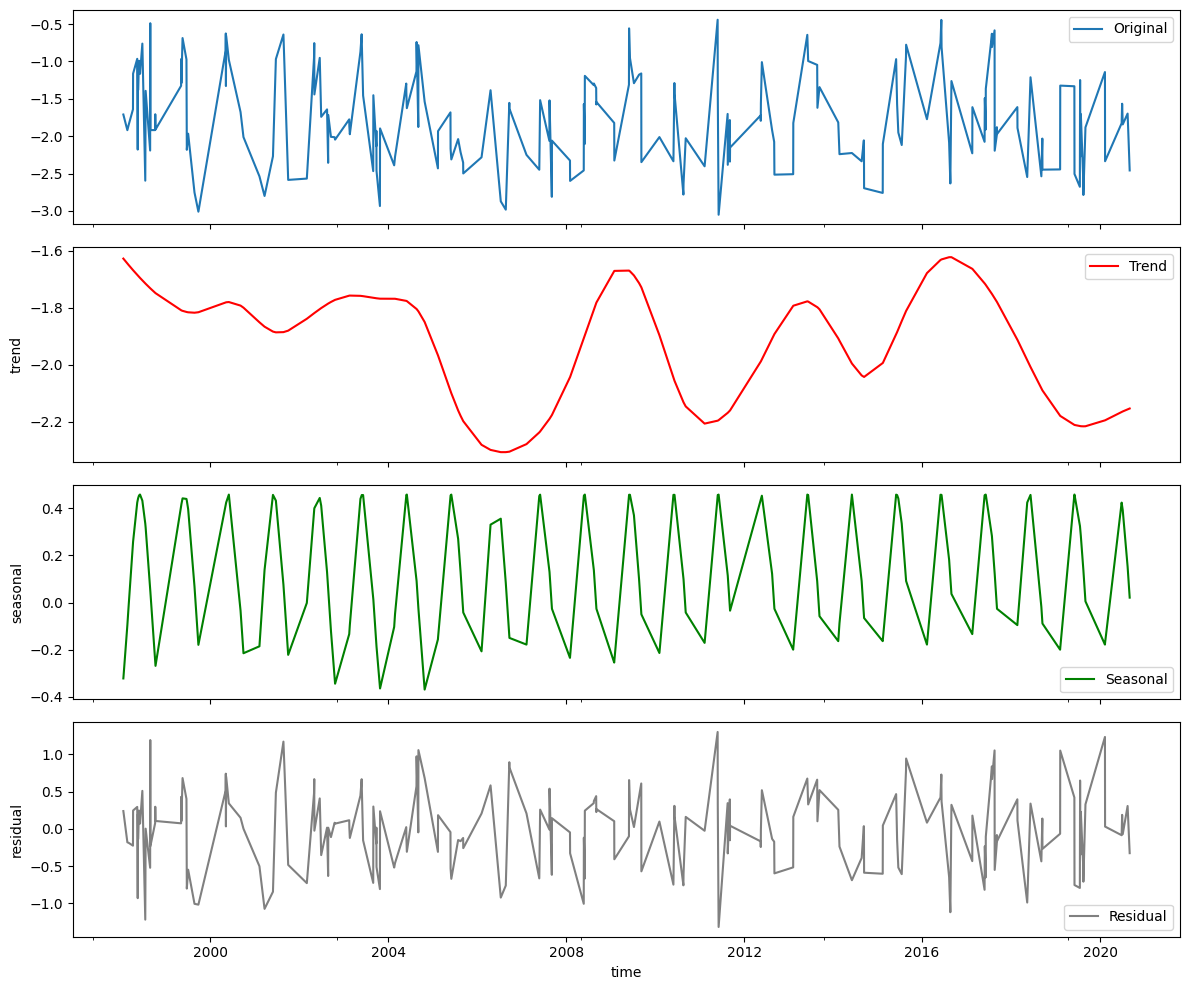

In [9]:
fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
ts.plot(ax=axs[0], label='Original'); axs[0].legend()
da_trend.plot(ax=axs[1], label='Trend', color='red'); axs[1].legend()
da_seasonal.plot(ax=axs[2], label='Seasonal', color='green'); axs[2].legend()
da_residual.plot(ax=axs[3], label='Residual', color='gray'); axs[3].legend()
plt.tight_layout()
plt.show()

/home/sroyer/mambaforge/envs/seapopym-opti2/lib/python3.12/site-packages/xarray/plot/dataarray_plot.py:512: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  primitive = ax.plot(xplt_val, yplt_val, *args, **kwargs)


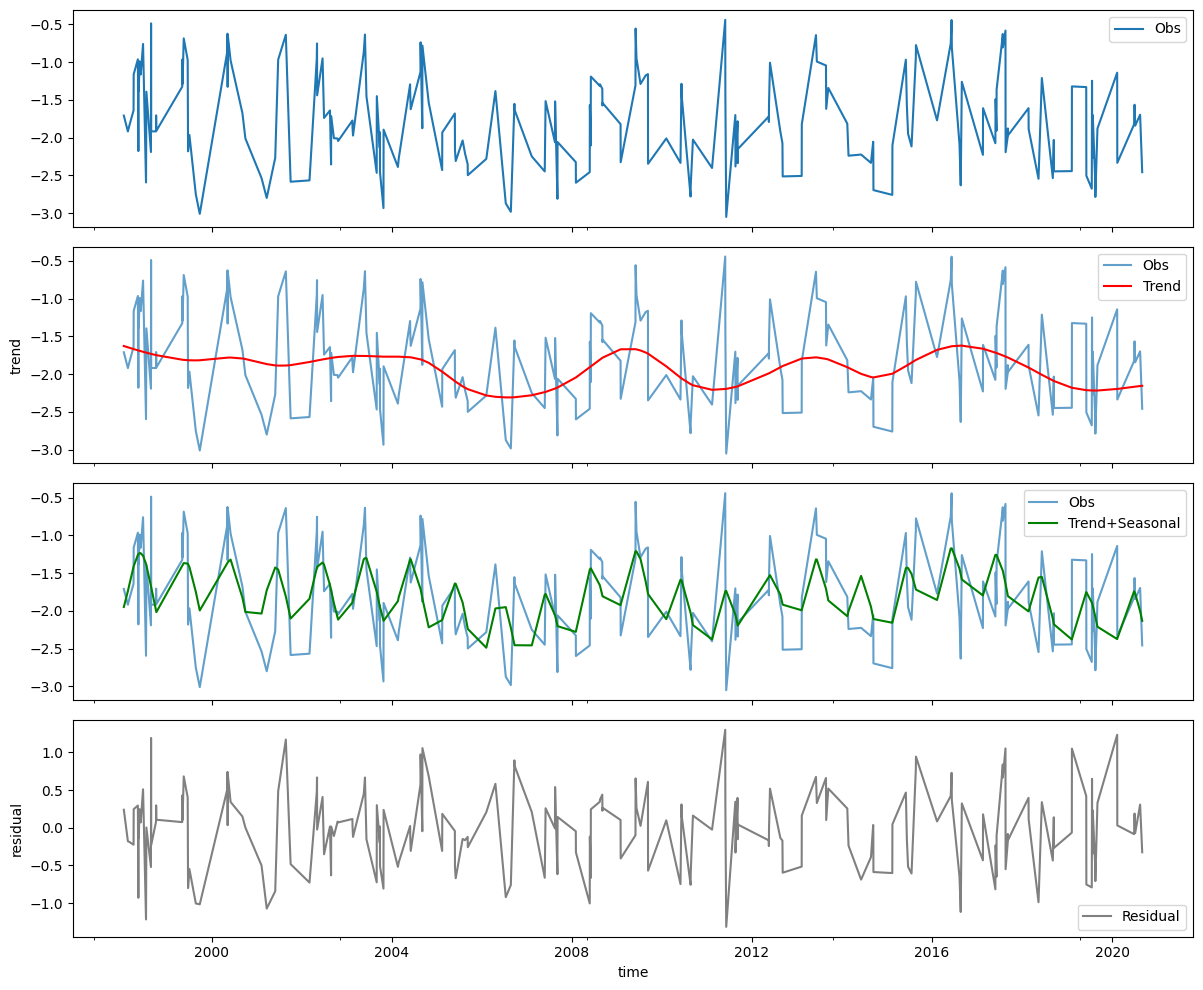

In [10]:
fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
ts.plot(ax=axs[0], label='Obs'); axs[0].legend()
ts.plot(ax=axs[1], alpha=0.7, label='Obs'); axs[0].legend()
ts.plot(ax=axs[2], alpha=0.7, label='Obs'); axs[0].legend()
da_trend.plot(ax=axs[1], label='Trend', color='red'); axs[1].legend()
(da_trend+da_seasonal).plot(ax=axs[2], label='Trend+Seasonal', color='green'); axs[2].legend()
da_residual.plot(ax=axs[3], label='Residual', color='gray'); axs[3].legend()
plt.tight_layout()
plt.show()

## test sur les mois

___

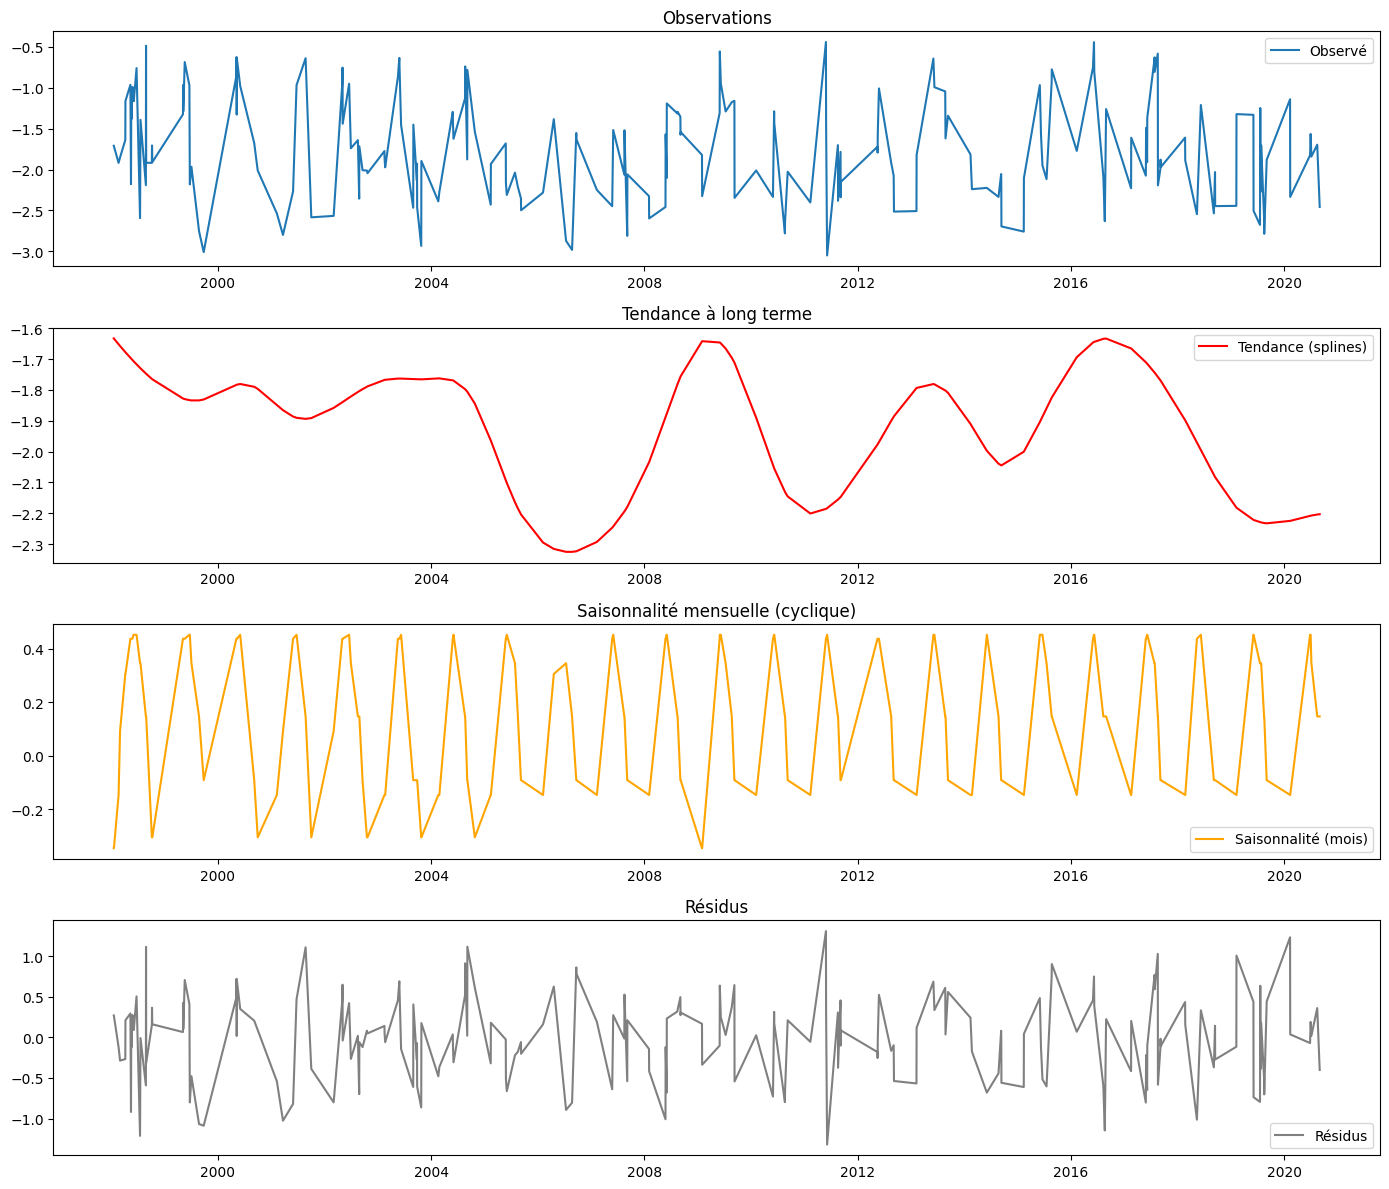

In [11]:
# 1. Préparer les données
df = pd.DataFrame()
df['time'] = data_pter['time'].values
df['pteropod_biomass_gm2'] = data_pter.values

# Convertir le temps en float (en jours depuis début)
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values('time')
df['time_float'] = (df['time'] - df['time'].min()).dt.total_seconds() / (3600 * 24)

# Extraire le mois et créer les variables cycliques
df['month'] = df['time'].dt.month
df['month_sin'] = np.sin(2 * np.pi * (df['month']-1) / 12)
df['month_cos'] = np.cos(2 * np.pi * (df['month']-1) / 12)

# 2. Ajuster un modéle GAM
X = df[['time_float', 'month_sin', 'month_cos']].values
y = df['pteropod_biomass_gm2'].values

gam = LinearGAM(s(0, n_splines=30) + l(1) + l(2),fit_intercept=False).fit(X, y)

# 3. Prédictions
y_pred = gam.predict(X)

# 4. Décomposer
trend = gam.partial_dependence(term=0, X=X)  # spline sur le temps
season = gam.partial_dependence(term=1, X=X) + gam.partial_dependence(term=2, X=X)
residuals = y - (trend + season)

# 5. Afficher les résultats
plt.figure(figsize=(14, 12))

plt.subplot(4, 1, 1)
plt.plot(df['time'], y, label='Observé')
plt.legend()
plt.title('Observations')

plt.subplot(4, 1, 2)
plt.plot(df['time'], trend, label='Tendance (splines)', color='red')
plt.legend()
plt.title('Tendance à long terme')

plt.subplot(4, 1, 3)
plt.plot(df['time'], season, label='Saisonnalité (mois)', color='orange')
plt.legend()
plt.title('Saisonnalité mensuelle (cyclique)')

plt.subplot(4, 1, 4)
plt.plot(df['time'], residuals, label='Résidus', color='gray')
plt.legend()
plt.title('Résidus')

plt.tight_layout()
plt.show()


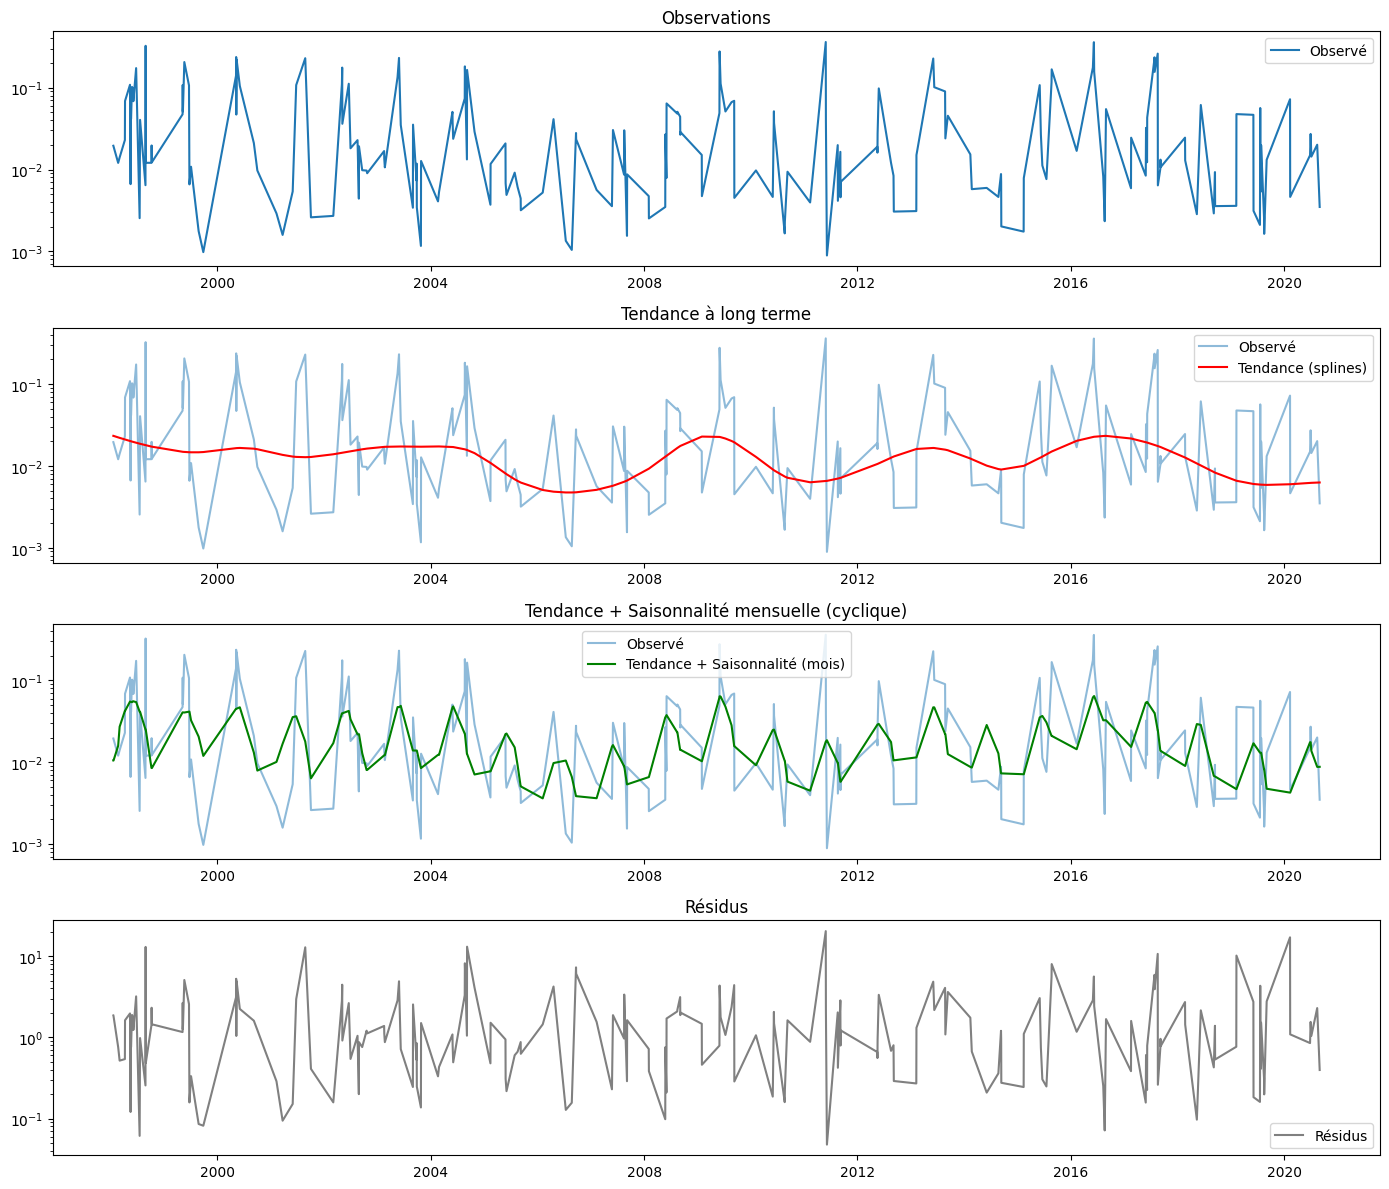

In [12]:
plt.figure(figsize=(14, 12))

plt.subplot(4, 1, 1)
plt.plot(df['time'], 10**y, label='Observé')
plt.yscale('log')
plt.legend()
plt.title('Observations')

plt.subplot(4, 1, 2)
plt.plot(df['time'], 10**y, alpha=0.5, label='Observé')
plt.plot(df['time'], 10**trend, label='Tendance (splines)', color='red')
plt.yscale('log')
plt.legend()
plt.title('Tendance à long terme')

plt.subplot(4, 1, 3)
plt.plot(df['time'], 10**y, alpha=0.5, label='Observé')
plt.plot(df['time'], 10**(trend+season), label='Tendance + Saisonnalité (mois)', color='green')
plt.yscale('log')
plt.legend()
plt.title('Tendance + Saisonnalité mensuelle (cyclique)')

plt.subplot(4, 1, 4)
plt.plot(df['time'], 10**residuals, label='Résidus', color='gray')
plt.yscale('log')
plt.legend()
plt.title('Résidus')

plt.tight_layout()
plt.show()

---
monthly avg obs

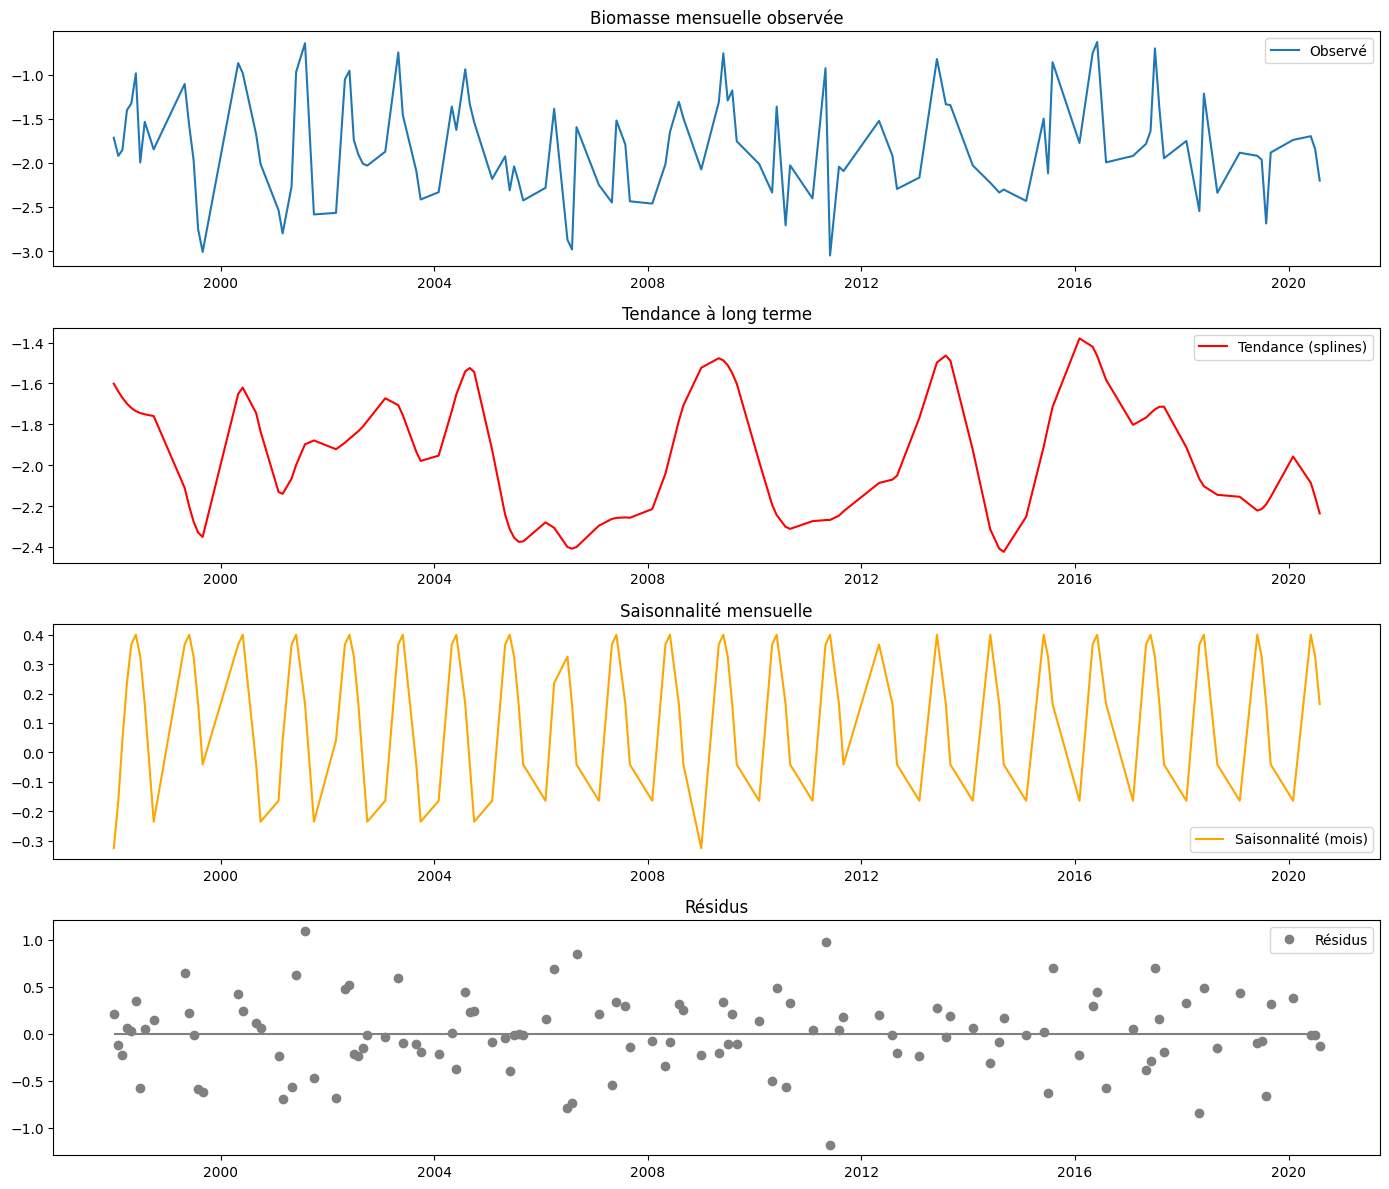

In [19]:
# 1. Préparer les données
df = pd.DataFrame()
df['time'] = pd.to_datetime(data_pter['time'].values)
df['pteropod_biomass_gm2'] = data_pter.values

# 2. Moyenne mensuelle
df['year_month'] = df['time'].dt.to_period('M')
monthly = df.groupby('year_month')['pteropod_biomass_gm2'].mean().to_timestamp()
monthly = monthly.asfreq('MS')  # Série temporelle régulière mensuelle

# 3. Remettre sous forme de DataFrame
df_monthly = monthly.reset_index()
df_monthly.rename(columns={'year_month': 'time', 'pteropod_biomass_gm2': 'biomass'}, inplace=True)
# Supprimer les lignes contenant des NaN
df_monthly = df_monthly.dropna()
df_monthly=df_monthly.reset_index(drop=True)
# 4. Convertir le temps en float (en jours depuis début)
df_monthly['time_float'] = (df_monthly['time'] - df_monthly['time'].min()).dt.total_seconds() / (3600 * 24)

# 5. Créer les variables cycliques pour le mois
df_monthly['month'] = df_monthly['time'].dt.month
df_monthly['month_sin'] = np.sin(2 * np.pi * (df_monthly['month'] - 1) / 12)
df_monthly['month_cos'] = np.cos(2 * np.pi * (df_monthly['month'] - 1) / 12)

# 6. Ajuster un modèle GAM
X = df_monthly[['time_float', 'month_sin', 'month_cos']].values
y = df_monthly['biomass'].values

gam = LinearGAM(s(0, n_splines=80) + l(1) + l(2), fit_intercept=False).fit(X, y)

# 7. Prédictions
y_pred = gam.predict(X)

# 8. Décomposition
trend = gam.partial_dependence(term=0, X=X)
season = gam.partial_dependence(term=1, X=X) + gam.partial_dependence(term=2, X=X)
residuals = y - (trend + season)

# 9. Affichage
plt.figure(figsize=(14, 12))

plt.subplot(4, 1, 1)
plt.plot(df_monthly['time'], y, label='Observé')
plt.legend()
plt.title('Biomasse mensuelle observée')

plt.subplot(4, 1, 2)
plt.plot(df_monthly['time'], trend, label='Tendance (splines)', color='red')
plt.legend()
plt.title('Tendance à long terme')

plt.subplot(4, 1, 3)
plt.plot(df_monthly['time'], season, label='Saisonnalité (mois)', color='orange')
plt.legend()
plt.title('Saisonnalité mensuelle')

plt.subplot(4, 1, 4)
plt.hlines(y=0, xmin=df_monthly['time'][0],xmax=df_monthly['time'][len(df_monthly['time'])-1],color='grey')
plt.plot(df_monthly['time'], residuals,'o', label='Résidus', color='gray')
plt.legend()
plt.title('Résidus')

plt.tight_layout()
plt.show()


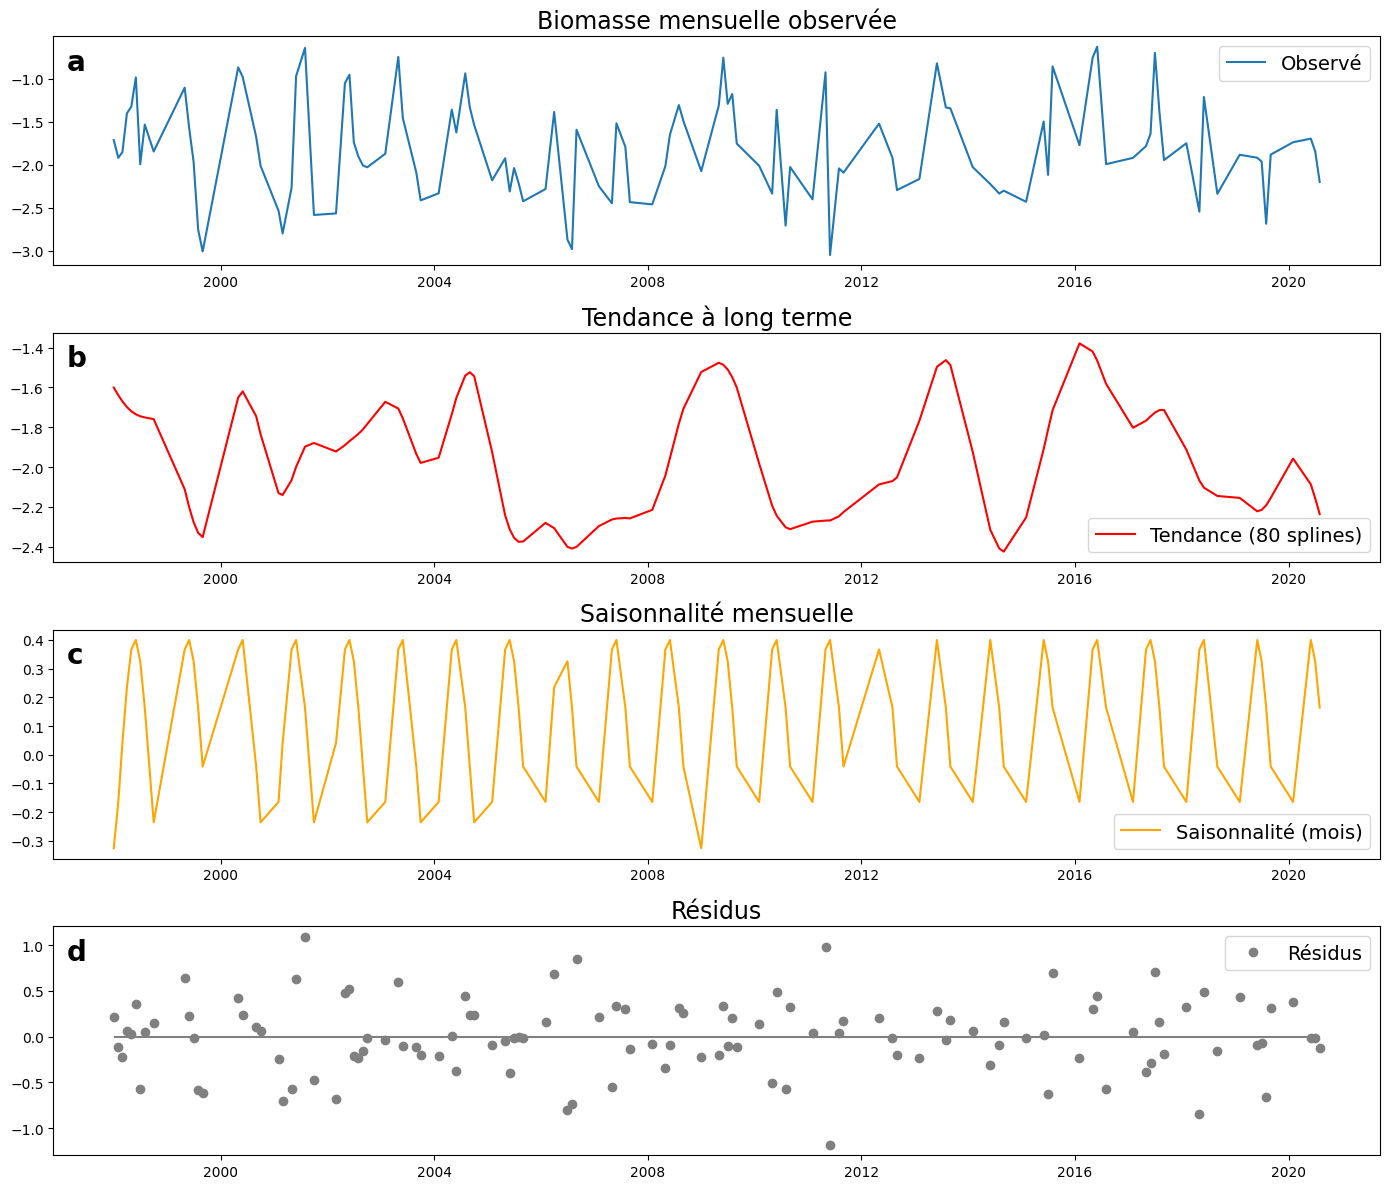

In [23]:
# 9. Affichage
plt.figure(figsize=(14, 12))

fontsize_title = 17
fontsize_labels = 14
fontsize_letters = 20

# Panel (a)
ax1 = plt.subplot(4, 1, 1)
plt.plot(df_monthly['time'], y, label='Observé')
plt.legend(fontsize=fontsize_labels)
plt.title('Biomasse mensuelle observée', fontsize=fontsize_title)
ax1.text(0.01, 0.95, 'a', transform=ax1.transAxes,
         fontsize=fontsize_letters, fontweight='bold', va='top', ha='left')

# Panel (b)
ax2 = plt.subplot(4, 1, 2)
plt.plot(df_monthly['time'], trend, label='Tendance (80 splines)', color='red')
plt.legend(fontsize=fontsize_labels)
plt.title('Tendance à long terme', fontsize=fontsize_title)
ax2.text(0.01, 0.95, 'b', transform=ax2.transAxes,
         fontsize=fontsize_letters, fontweight='bold', va='top', ha='left')

# Panel (c)
ax3 = plt.subplot(4, 1, 3)
plt.plot(df_monthly['time'], season, label='Saisonnalité (mois)', color='orange')
plt.legend(fontsize=fontsize_labels)
plt.title('Saisonnalité mensuelle', fontsize=fontsize_title)
ax3.text(0.01, 0.95, 'c', transform=ax3.transAxes,
         fontsize=fontsize_letters, fontweight='bold', va='top', ha='left')

# Panel (d)
ax4 = plt.subplot(4, 1, 4)
plt.hlines(
    y=0,
    xmin=df_monthly['time'].iloc[0],
    xmax=df_monthly['time'].iloc[-1],
    color='grey'
)
plt.plot(df_monthly['time'], residuals, 'o', label='Résidus', color='gray')
plt.legend(fontsize=fontsize_labels)
plt.title('Résidus', fontsize=fontsize_title)
ax4.text(0.01, 0.95, 'd', transform=ax4.transAxes,
         fontsize=fontsize_letters, fontweight='bold', va='top', ha='left')

plt.tight_layout()
plt.show()


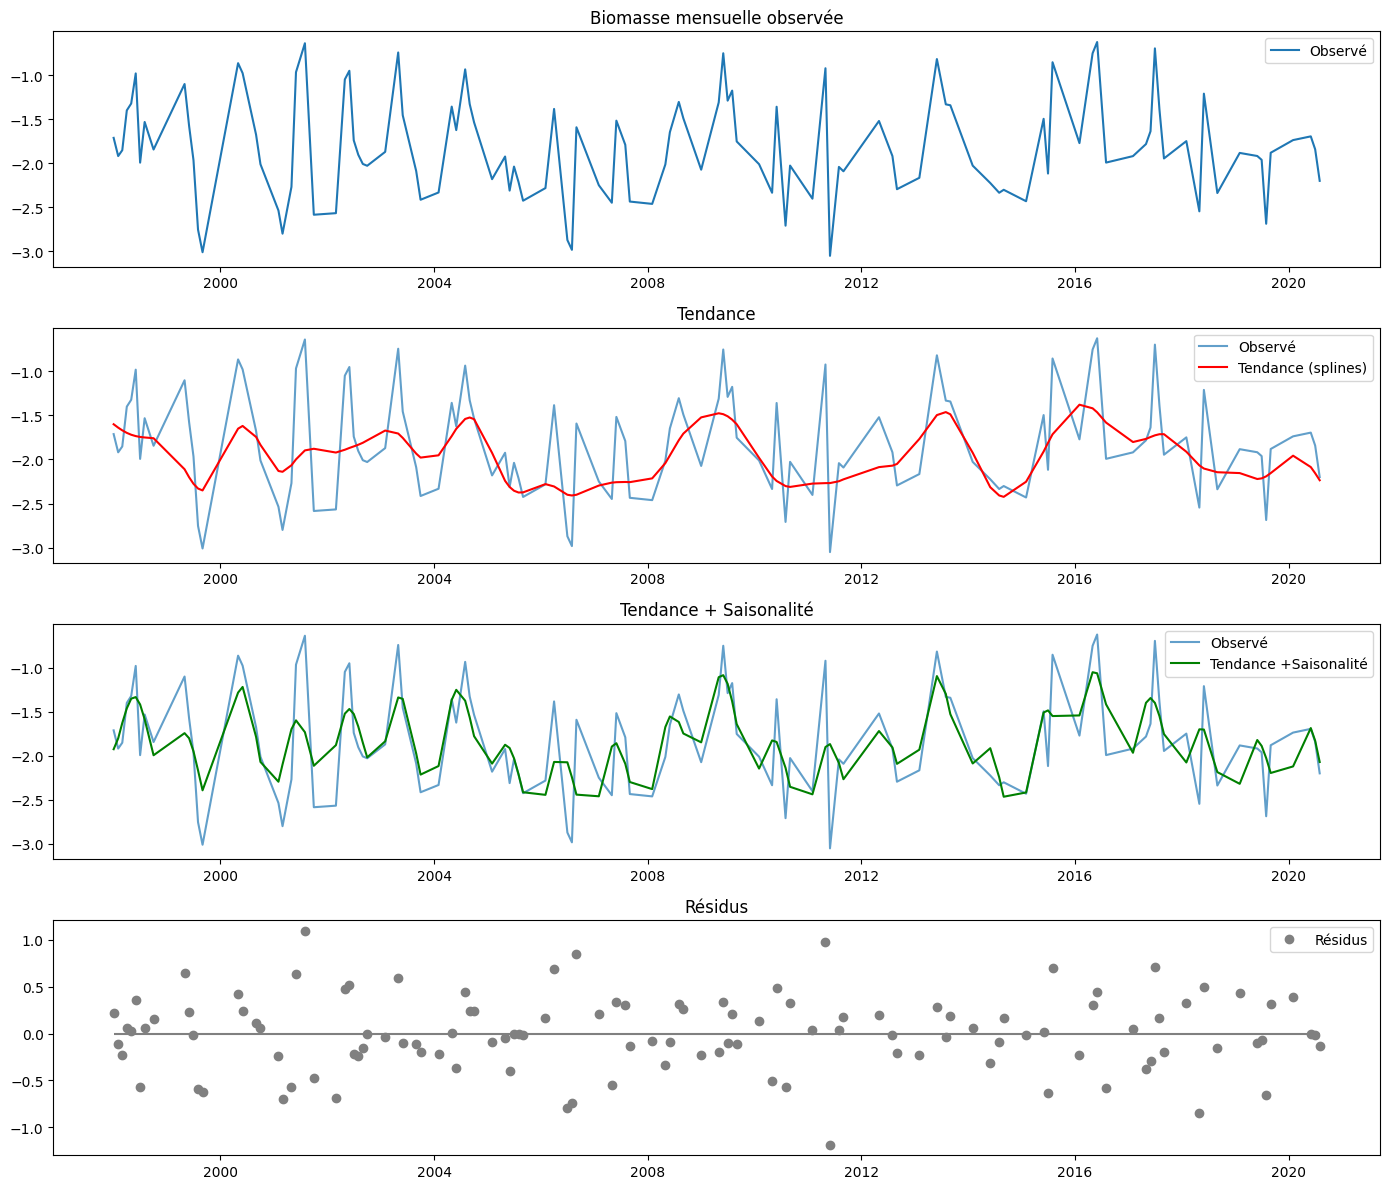

In [14]:
plt.figure(figsize=(14, 12))

plt.subplot(4, 1, 1)
plt.plot(df_monthly['time'], y, label='Observé')
plt.legend()
plt.title('Biomasse mensuelle observée')

plt.subplot(4, 1, 2)
plt.plot(df_monthly['time'], y, label='Observé',alpha=0.7)
plt.plot(df_monthly['time'], trend, label='Tendance (splines)', color='red')
plt.legend()
plt.title('Tendance')

plt.subplot(4, 1, 3)
plt.plot(df_monthly['time'], y, label='Observé',alpha=0.7)
plt.plot(df_monthly['time'], trend+season, label='Tendance +Saisonalité', color='green')
plt.legend()
plt.title('Tendance + Saisonalité')

plt.subplot(4, 1, 4)
plt.hlines(y=0, xmin=df_monthly['time'][0],xmax=df_monthly['time'][len(df_monthly['time'])-1],color='grey')
plt.plot(df_monthly['time'], residuals,'o', label='Résidus', color='gray')
plt.legend()
plt.title('Résidus')

plt.tight_layout()
plt.show()


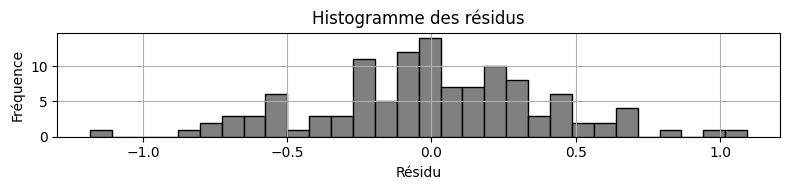

In [15]:
plt.figure(figsize=(8, 2))
plt.hist(residuals, bins=30, color='gray', edgecolor='black')
plt.title('Histogramme des résidus')
plt.xlabel('Résidu')
plt.ylabel('Fréquence')
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     32.3449
Link Function:                     IdentityLink Log Likelihood:                                  -123.3968
Number of Samples:                          117 AIC:                                              313.4835
                                                AICc:                                             341.1946
                                                GCV:                                                0.4201
                                                Scale:                                              0.2182
                                                Pseudo R-Squared:                                   0.5129
Feature Function                  Lam

/tmp/ipykernel_58613/3358381670.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


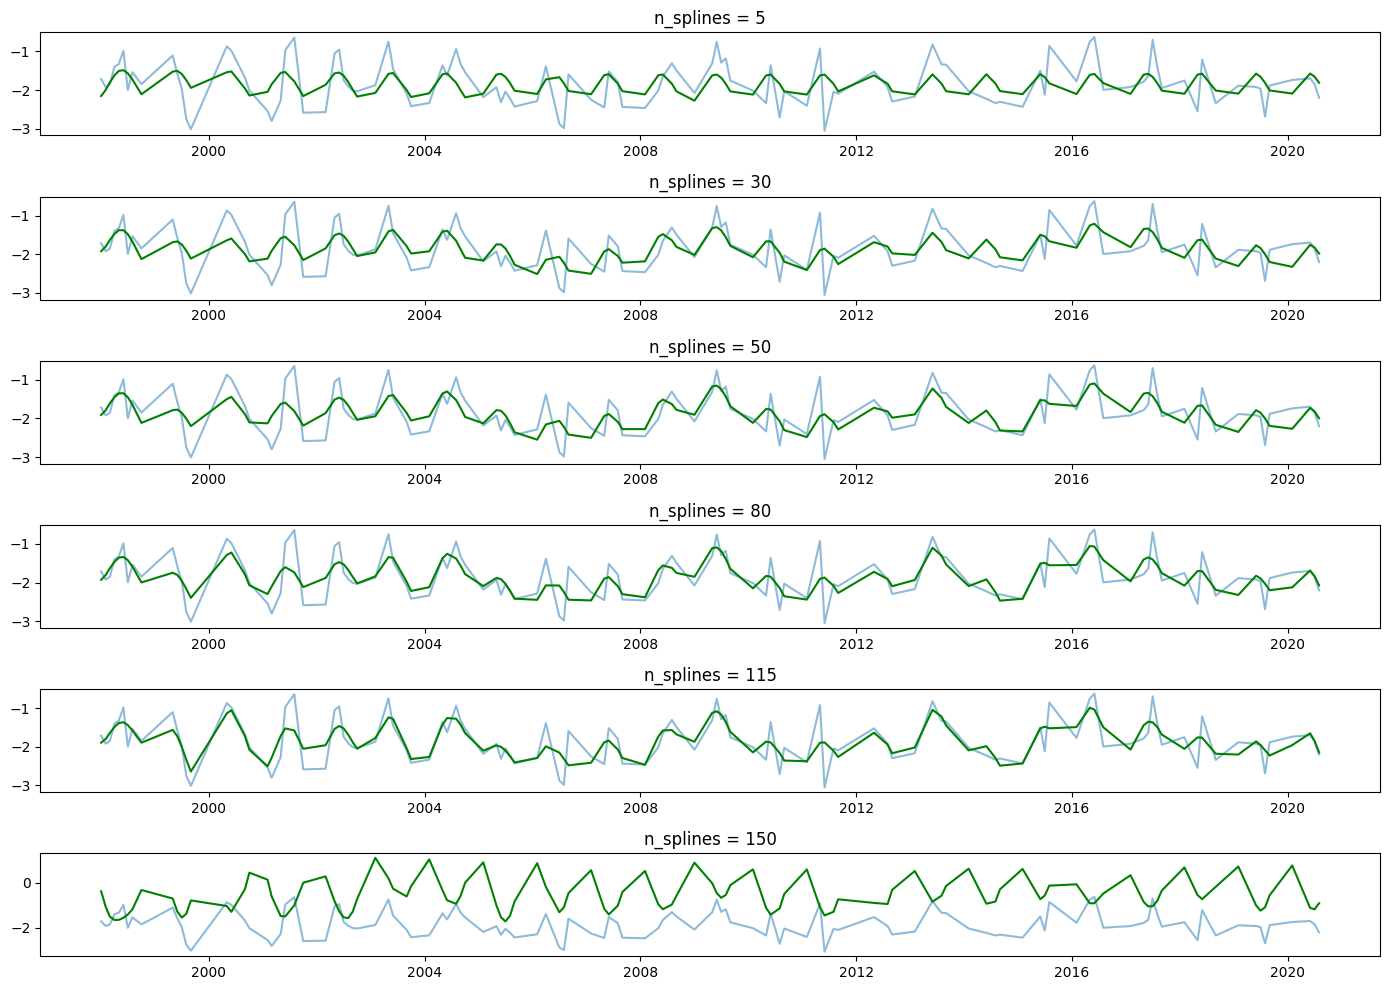

In [17]:
# choisir n_splines
# Définir X et y
X = df_monthly[['time_float', 'month_sin', 'month_cos']].values
y = df_monthly['biomass'].values

# Tester différentes valeurs de n_splines
spline_values = [5, 30, 50, 80, 115,150]
plt.figure(figsize=(14, 10))

for i, n in enumerate(spline_values, 1):
    gam = LinearGAM(s(0, n_splines=n) + l(1) + l(2), fit_intercept=False).fit(X, y)
    
    trend = gam.partial_dependence(term=0, X=X)
    season = gam.partial_dependence(term=1, X=X) + gam.partial_dependence(term=2, X=X)

    plt.subplot(len(spline_values), 1, i)
    plt.plot(df_monthly['time'], y, label='Observé', alpha=0.5)
    plt.plot(df_monthly['time'], trend+season, color='green', label=f'Tendance +Saisonalité (n_splines={n})')
    # plt.plot(df_monthly['time'], trend, color='red', label=f'Tendance(n_splines={n})')
    # plt.legend()
    plt.title(f'n_splines = {n}')
    
plt.tight_layout()
plt.show()


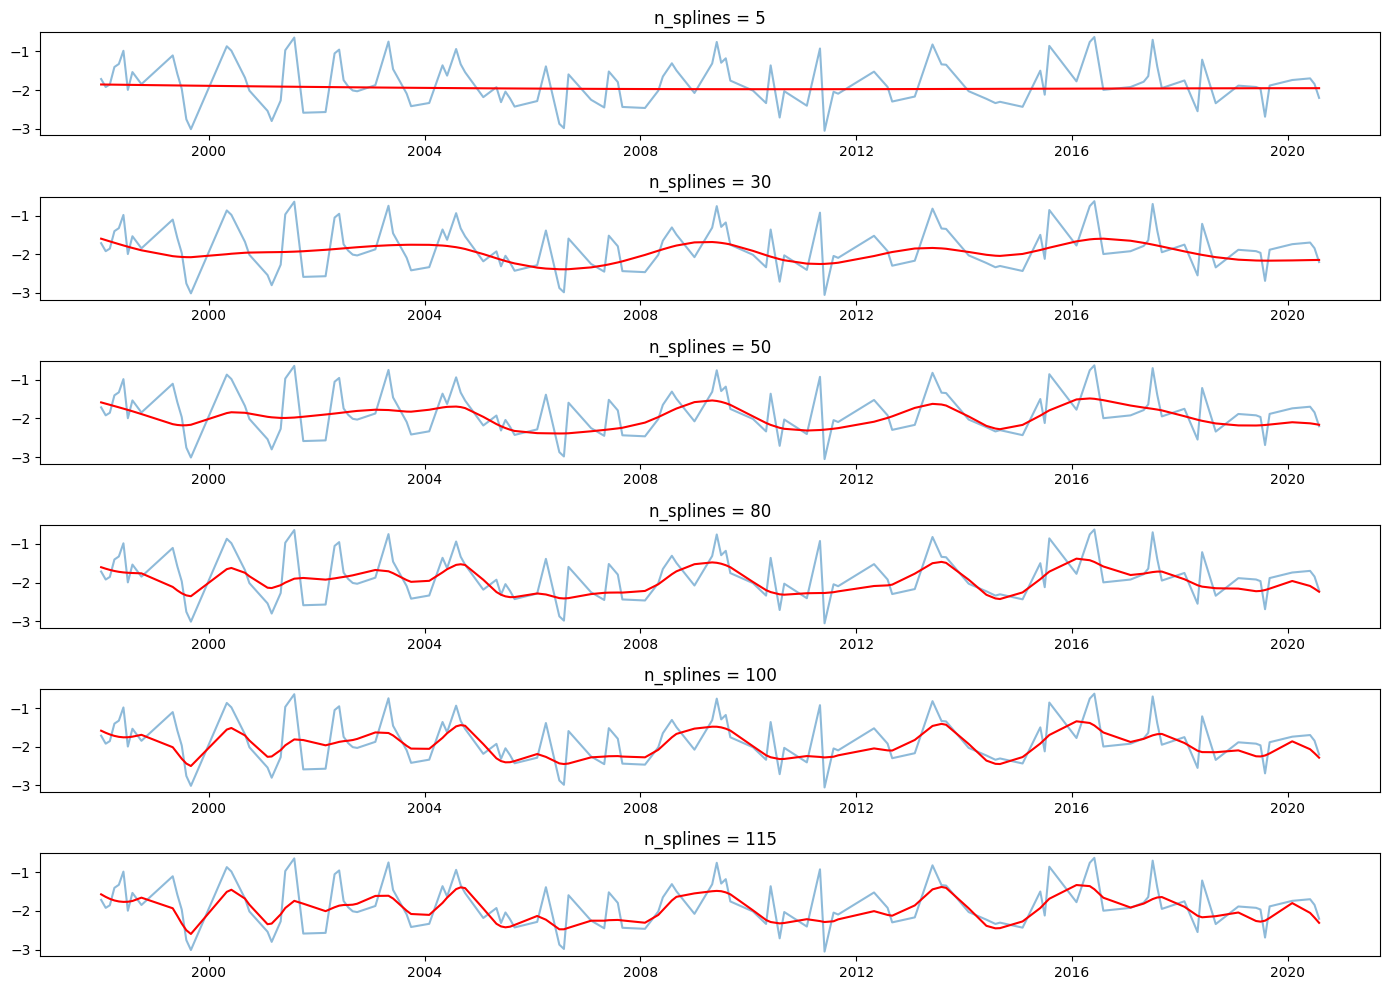

In [18]:
# choisir n_splines
# Définir X et y
X = df_monthly[['time_float', 'month_sin', 'month_cos']].values
y = df_monthly['biomass'].values

# Tester différentes valeurs de n_splines
spline_values = [5, 30, 50, 80, 100,115]
plt.figure(figsize=(14, 10))

for i, n in enumerate(spline_values, 1):
    gam = LinearGAM(s(0, n_splines=n) + l(1) + l(2), fit_intercept=False).fit(X, y)
    
    trend = gam.partial_dependence(term=0, X=X)
    season = gam.partial_dependence(term=1, X=X) + gam.partial_dependence(term=2, X=X)

    plt.subplot(len(spline_values), 1, i)
    plt.plot(df_monthly['time'], y, label='Observé', alpha=0.5)
    # plt.plot(df_monthly['time'], trend+season, color='green', label=f'Tendance +Saisonalité (n_splines={n})')
    plt.plot(df_monthly['time'], trend, color='red', label=f'Tendance(n_splines={n})')
    # plt.legend()
    plt.title(f'n_splines = {n}')
    
plt.tight_layout()
plt.show()


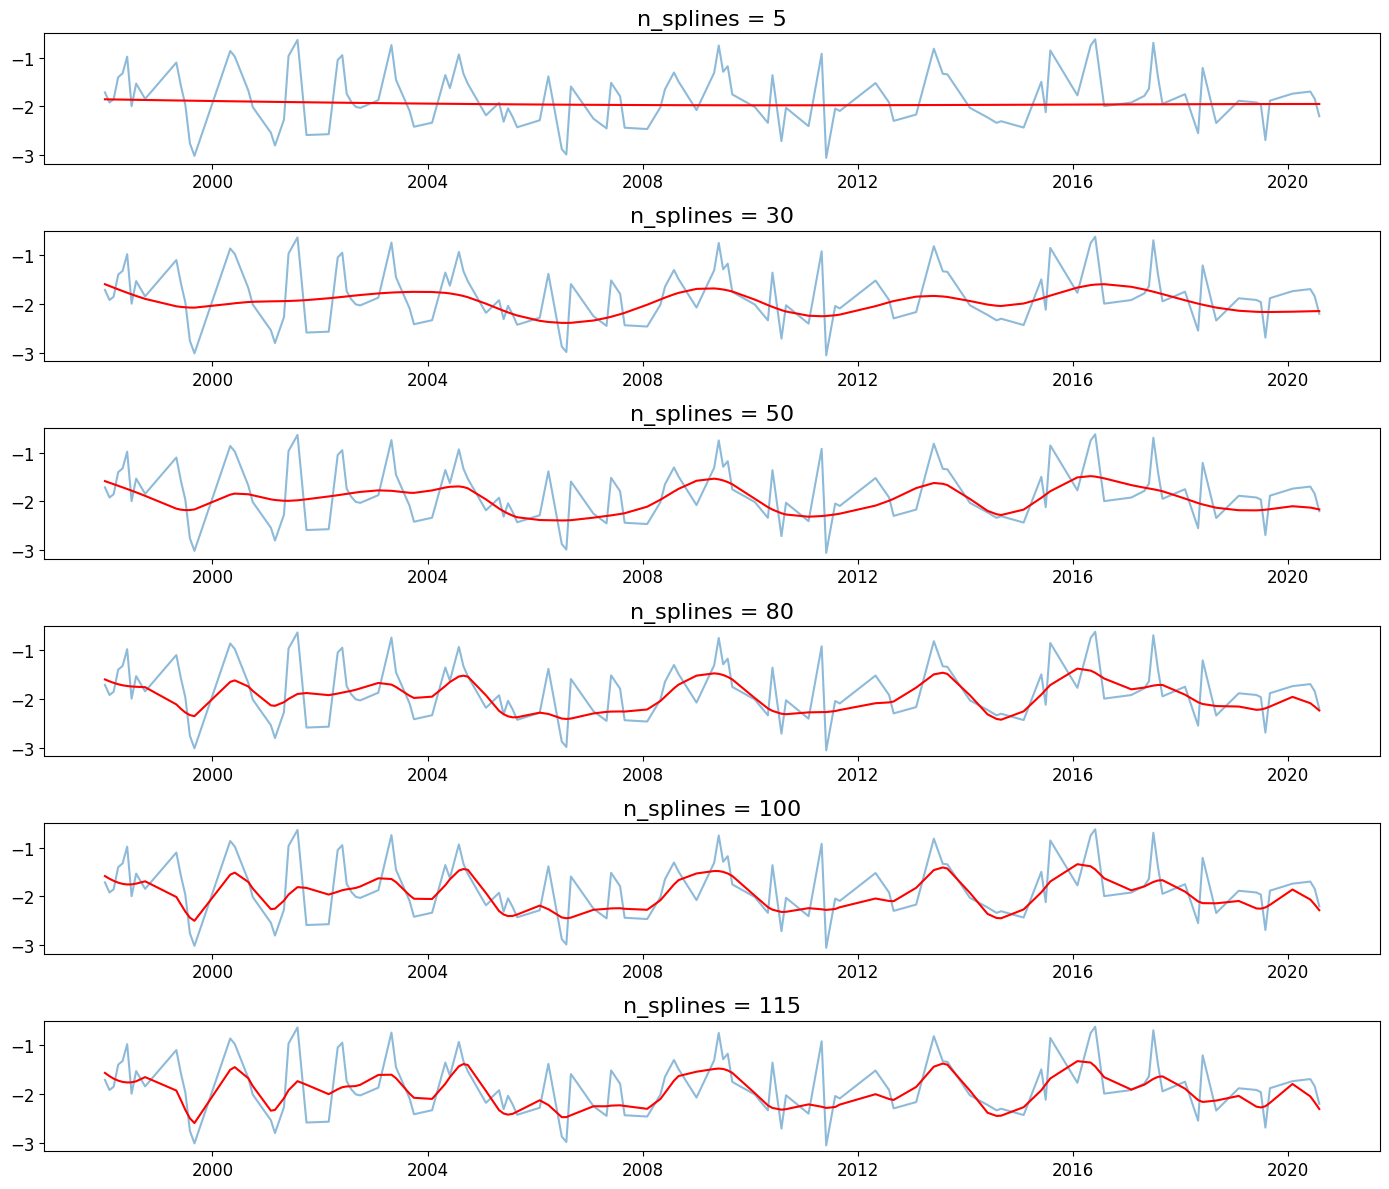

In [26]:
from pygam import LinearGAM, s, l
import matplotlib.pyplot as plt

# Définir X et y
X = df_monthly[['time_float', 'month_sin', 'month_cos']].values
y = df_monthly['biomass'].values

# Tester différentes valeurs de n_splines
spline_values = [5, 30, 50, 80, 100, 115]

# Ajuster les paramètres globaux de police
plt.rcParams.update({
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12
})

plt.figure(figsize=(14, 12))

for i, n in enumerate(spline_values, 1):
    gam = LinearGAM(s(0, n_splines=n) + l(1) + l(2), fit_intercept=False).fit(X, y)
    
    trend = gam.partial_dependence(term=0, X=X)
    season = gam.partial_dependence(term=1, X=X) + gam.partial_dependence(term=2, X=X)

    ax = plt.subplot(len(spline_values), 1, i)
    ax.plot(df_monthly['time'], y, label='Observé', alpha=0.5)
    ax.plot(df_monthly['time'], trend, color='red', label=f'Tendance (n_splines={n})')
    
    ax.set_title(f'n_splines = {n}', fontsize=16)
    ax.tick_params(axis='both', labelsize=12)
    # ax.legend(fontsize=12)

plt.tight_layout()
plt.show()


In [192]:
# choisir n_splines
# Définir X et y
X = df_monthly[['time_float', 'month_sin', 'month_cos']].values
y = df_monthly['biomass'].values

# Tester différentes valeurs de n_splines
spline_values = [5, 10, 20, 30, 50, 80, 115]
plt.figure(figsize=(14, 10))

for i, n in enumerate(spline_values, 1):
    gam = LinearGAM(s(0, n_splines=n) + l(1) + l(2), fit_intercept=False).fit(X, y)
    
    trend = gam.partial_dependence(term=0, X=X)
    season = gam.partial_dependence(term=1, X=X) + gam.partial_dependence(term=2, X=X)
    residuals = y - (trend + season)
    print(f"n_spline :{n}")
    print(f"std :{np.std(residuals)}")
    print(f"mean:{np.mean(residuals)}")
    


n_spline :5
std :0.5221401847300227
mean:-1.1974541054833006e-09
n_spline :10
std :0.5143278440570668
mean:-2.5166231245181616e-09
n_spline :20
std :0.48380644509439513
mean:-4.932645875800363e-09
n_spline :30
std :0.46216284056387175
mean:-7.426039101781952e-09
n_spline :50
std :0.4353021479812941
mean:-1.247810298962348e-08
n_spline :80
std :0.3973125408037813
mean:-1.9970199236913974e-08
n_spline :115
std :0.36193353549717333
mean:-2.8607655593904006e-08


<Figure size 1400x1000 with 0 Axes>

## quels paramètres choisir pour fit ? (n_spline)
--- 

In [157]:
#  80% pour entrainer, 20% pour tester
split_idx = int(len(df_monthly) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [158]:
errors = []
for n_splines in [5, 10, 15, 20, 30, 50]:
    gam = LinearGAM(s(0, n_splines=n_splines) + l(1) + l(2), fit_intercept=False)
    gam.fit(X_train, y_train)
    y_pred = gam.predict(X_test)
    rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
    errors.append((n_splines, rmse))

# Afficher l'erreur minimale
best = min(errors, key=lambda x: x[1])
print(f"Best n_splines: {best[0]} with RMSE: {best[1]:.3f}")


Best n_splines: 5 with RMSE: 0.555


  0%|          | 0/18 [00:00<?, ?it/s]

100%|██████████| 18/18 [00:02<00:00,  6.12it/s]


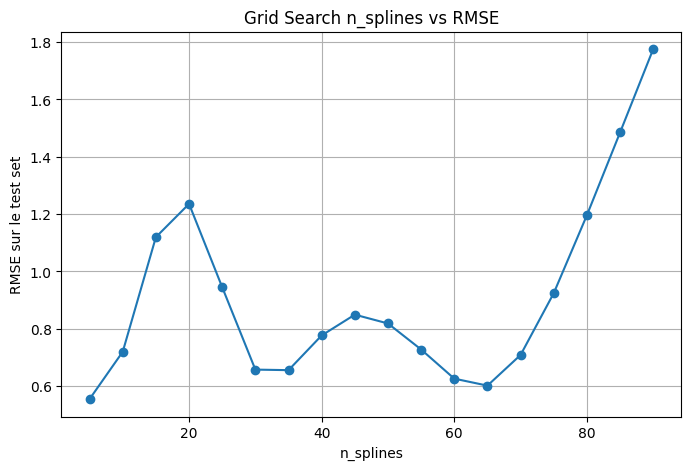

Meilleur n_splines: 5.0 avec RMSE = 0.5548


In [209]:
import numpy as np
import pandas as pd
from pygam import LinearGAM, s, l
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm

results = []
n_spline_grid = range(5, 91, 5)

for n in tqdm(n_spline_grid):
    gam = LinearGAM(s(0, n_splines=n) + l(1) + l(2), fit_intercept=False)
    gam.fit(X_train, y_train)
    y_pred = gam.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results.append((n, rmse))

# Convertir les r�sultats en DataFrame
df_results = pd.DataFrame(results, columns=['n_splines', 'RMSE'])

# --- 4. Afficher les r�sultats ---
plt.figure(figsize=(8, 5))
plt.plot(df_results['n_splines'], df_results['RMSE'], marker='o')
plt.xlabel('n_splines')
plt.ylabel('RMSE sur le test set')
plt.title('Grid Search n_splines vs RMSE')
plt.grid(True)
plt.show()

# --- 5. Meilleur n_splines ---
best_n = df_results.loc[df_results['RMSE'].idxmin()]
print(f"Meilleur n_splines: {best_n['n_splines']} avec RMSE = {best_n['RMSE']:.4f}")


# STL

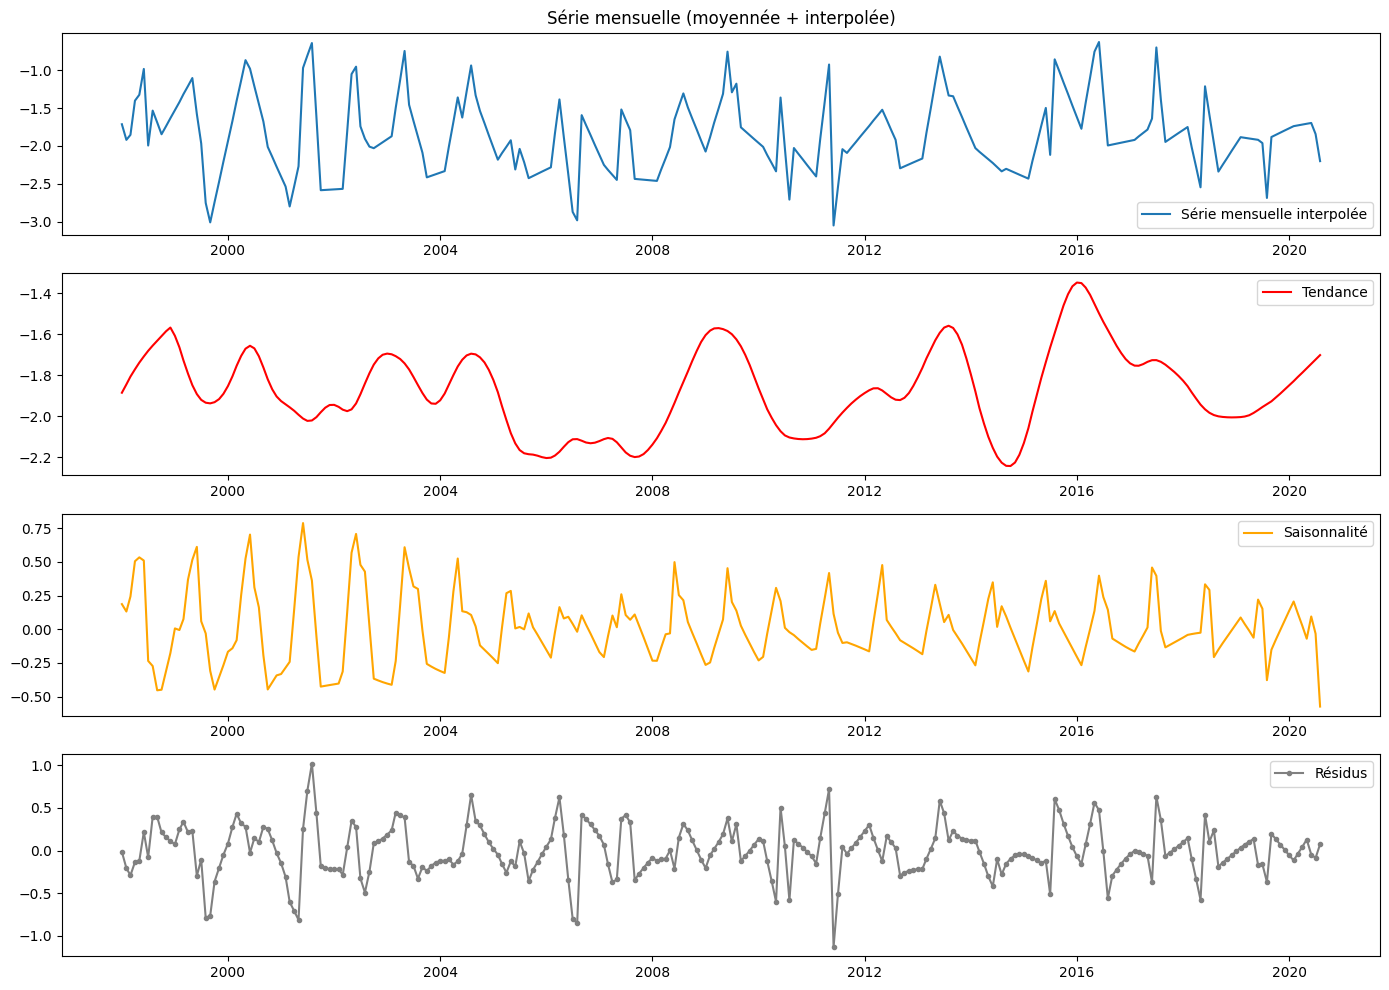

In [101]:
from statsmodels.tsa.seasonal import STL

# 1. Transformer les données
df_STL = pd.DataFrame({
    'time': pd.to_datetime(data_pter['time'].values),
    'biomass': data_pter.values
})

# 2. Grouper par mois (année-mois) et moyenne
df_STL['year_month'] = df_STL['time'].dt.to_period('M')
monthly_avg = df_STL.groupby('year_month')['biomass'].mean().to_timestamp()

# 3. Recréer une série régulière mensuelle compléte
monthly_avg = monthly_avg.asfreq('MS')  # 'MS' = Month Start

# 4. Interpolation linéaire des mois manquants (si irrégulier)
monthly_interp = monthly_avg.interpolate(method='linear')

# 5. STL
stl = STL(monthly_interp, period=12)
res = stl.fit()

# 6. Affichage
plt.figure(figsize=(14, 10))

plt.subplot(4, 1, 1)
plt.plot(monthly_interp, label='Série mensuelle interpolée')
plt.legend()
plt.title('Série mensuelle (moyennée + interpolée)')

plt.subplot(4, 1, 2)
plt.plot(res.trend, label='Tendance', color='red')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(res.seasonal, label='Saisonnalité', color='orange')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(res.resid, label='Résidus', color='gray',marker='.')
plt.legend()

plt.tight_layout()
plt.show()


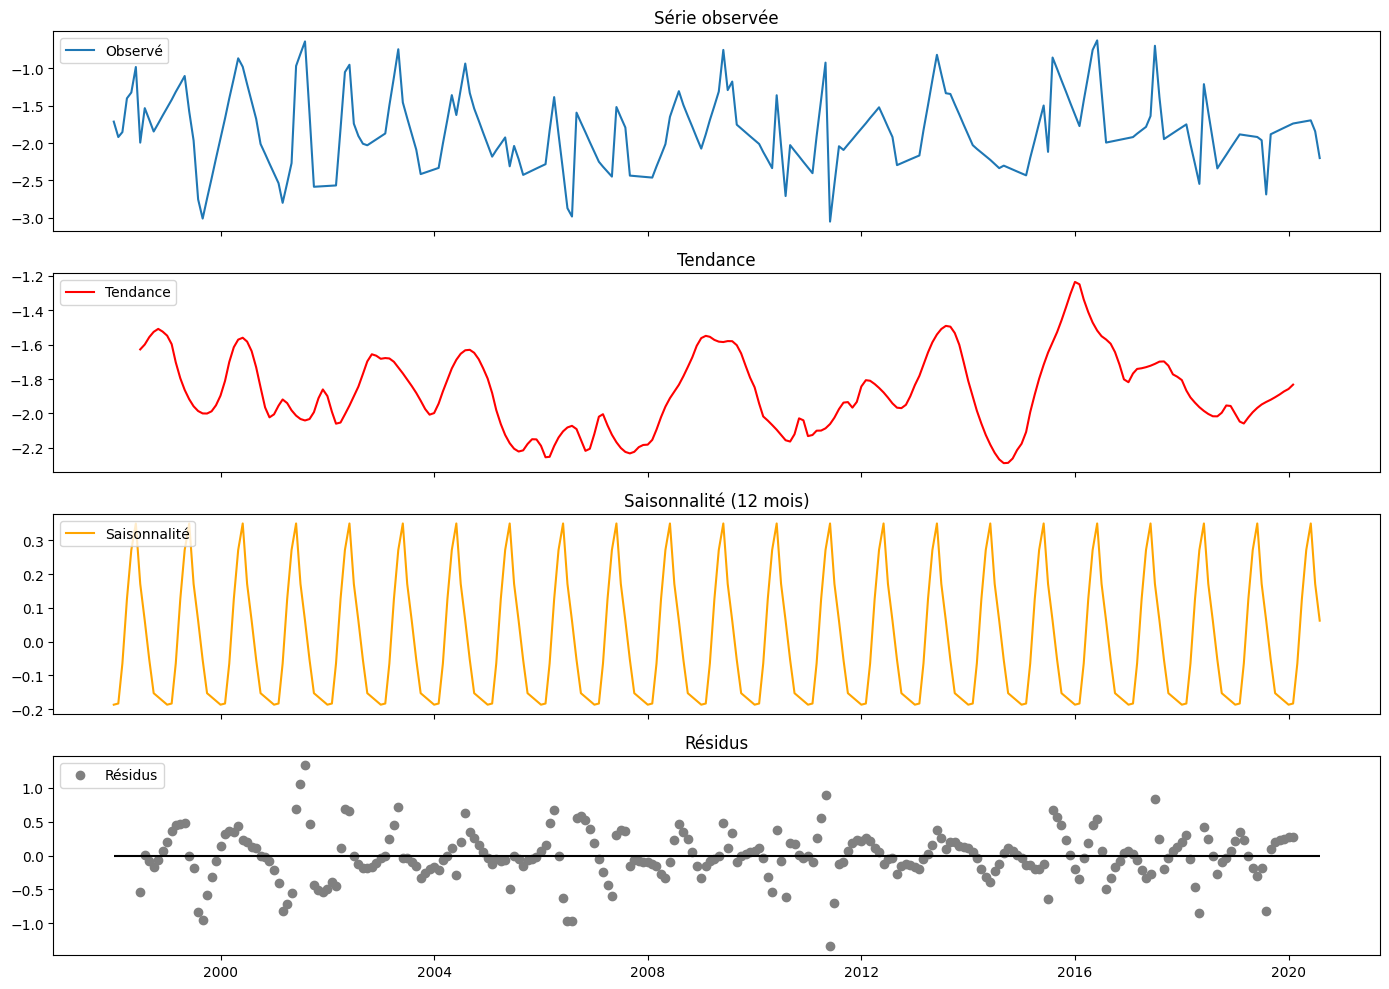

In [204]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(monthly_interp, model='additive', period=12)

# 3. Affichage
fig, axs = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

axs[0].plot(result.observed, label='Observé')
axs[0].legend(loc='upper left')
axs[0].set_title('Série observée')

axs[1].plot(result.trend, label='Tendance', color='red')
axs[1].legend(loc='upper left')
axs[1].set_title('Tendance')

axs[2].plot(result.seasonal, label='Saisonnalité', color='orange')
axs[2].legend(loc='upper left')
axs[2].set_title('Saisonnalité (12 mois)')

axs[3].plot(result.resid,'o', label='Résidus', color='gray')
axs[3].hlines(y=0,xmin=monthly_interp.index[0],xmax=monthly_interp.index[-1],color='black')
axs[3].legend(loc='upper left')
axs[3].set_title('Résidus')

plt.tight_layout()
plt.show()

In [196]:
print(np.std(result.resid))
print(np.mean(result.resid))

0.3528137892900412
7.625456314344722e-05
